# Import

In [1]:
import os
import torch
import pytorch_lightning as pl
from time import time_ns
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from rnaquanet.network.graph_regression_network import GraphRegressionNetwork
from rnaquanet.network.grn_data_module import GRNDataModule
from rnaquanet.utils.rnaquanet_config import RnaquanetConfig
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from torch.optim import Adam
from torch.nn import (
    BatchNorm1d,
    Identity,
    ReLU,
    LeakyReLU,
    Linear,
    MSELoss
)
import torch.nn.functional as F
from torch_geometric.nn import (
    GATConv,
    GCNConv,
    Sequential,
    global_mean_pool,
    BatchNorm,
)
from torch_geometric.nn.models import (
    GAT
)
from torch_geometric.loader import DataLoader
import numpy as np
from rnaquanet.data.preprocessing.hdf5_utils import load_data_from_hdf5
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from rnaquanet.network.h5_graph_dataset import H5GraphDataset
import math

In [2]:
descriptor_train_data = H5GraphDataset('/app/data/rnaquadataset_descriptor/train.h5', max_iterations=48000).__enter__()
descriptor_val_data = H5GraphDataset('/app/data/rnaquadataset_descriptor/val.h5', max_iterations=48000).__enter__()

rnaqua_train_data = H5GraphDataset('/app/data/rnaquadataset/train.h5').__enter__()
rnaqua_val_data = H5GraphDataset('/app/data/rnaquadataset/val.h5').__enter__()

ares_train_data = H5GraphDataset('/app/data/ares/train.h5').__enter__()
ares_val_data = H5GraphDataset('/app/data/ares/val.h5').__enter__()
ares_test_data = H5GraphDataset('/app/data/ares/test.h5').__enter__()

In [3]:
def plot_loss_chart(losses, epoch):
    bars = len(losses.values()) # num of bars
    epochs = range(1, epoch+2)
    width = 1.0/bars * 0.75
    multiplier = 0
    _, ax = plt.subplots(layout='constrained')

    for key, value in losses.items():
        x = np.arange(len(value['losses']))

        loss_values = value['losses']
        offset = width * multiplier
        rects = ax.bar(x + offset, loss_values, width, label=key, color=value['color'], alpha=0.5)
        ax.bar_label(rects, fmt='%0.0f', padding=3)
        multiplier += 1

    x = np.arange(len(epochs))
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(x + ((bars-1)/2)*width, epochs)
    ax.legend()
    plt.show()

def get_desc(epoch, losses):
    desc = f'Epoch {epoch+1}\n'
    for key, value in losses.items():
        if value['losses']:
            desc += f'Prev {key} {value["losses"][-1]:.2f}\tBest {key} {np.min(value["losses"]):.2f}\n'
    return desc.rstrip('\n')

def process_epoch(
        epoch, 
        batch_size, 
        device, 
        model,
        loss_fn,
        mse_no_reduce,
        optimizer,
        patience, 
        
        losses, key
    ):
    step = []

    if losses[key]['data'].max_iterations != None:
        losses[key]['data'].shuffle()
    

    with tqdm(total=len(losses[key]['data']), desc=f'{key.capitalize()} epoch {epoch+1}', position=0, leave=True) as progressbar:
        if not losses[key]['train']:
            with torch.no_grad():
                for item in DataLoader(losses[key]['data'], batch_size=batch_size, shuffle=False, num_workers=4):
                    item = item.to(device)
                    y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
                    step.extend(mse_no_reduce(y_pred, item.y).cpu().tolist())
                    progressbar.update(item.y.cpu().shape[0])
        else:
            for item in DataLoader(losses[key]['data'], batch_size=batch_size, shuffle=False, num_workers=4):
                item = item.to(device)
                y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
                loss = loss_fn(y_pred, item.y)
                step.extend(mse_no_reduce(y_pred, item.y).cpu().tolist())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                progressbar.update(item.y.cpu().shape[0])
        
    losses[key]['losses'].append(np.mean(step))
    clear_output(wait=True)
    print(get_desc(epoch, losses))
    plot_loss_chart(losses, epoch)

    index = np.argmin(losses[key]['losses'])
    return losses[key]['patience'] and index <= (epoch-patience)

Epoch 16
Prev train 38.97	Best train 35.73
Prev val 32.44	Best val 32.22
Prev ares train 89.65	Best ares train 73.60
Prev ares val 76.57	Best ares val 72.20
Prev ares test 69.79	Best ares test 53.73


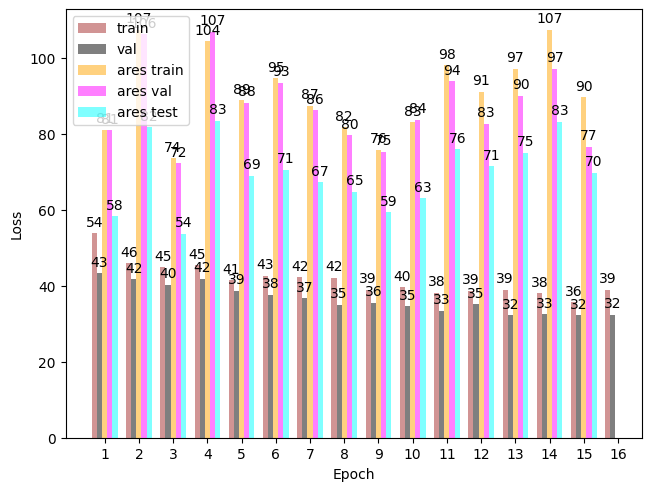

In [4]:
torch.set_float32_matmul_precision('high')
torch.manual_seed(2137)
device = torch.device('cuda:0')

max_epochs = 1000
batch_size = 64
patience = 3

model = Sequential('x, edge_index, edge_attr, batch', [
    (GATConv(in_channels=9, out_channels=128, heads=8, dropout=0.5), 'x, edge_index, edge_attr -> x'),
    (BatchNorm(in_channels=128*8), 'x -> x'),
    (ReLU(), 'x -> x'),

    (GATConv(in_channels=128*8, out_channels=128, heads=8, dropout=0.3), 'x, edge_index, edge_attr -> x'),
    (BatchNorm(in_channels=128*8), 'x -> x'),
    (ReLU(), 'x -> x'),

    (GATConv(in_channels=128*8, out_channels=128, heads=8, dropout=0.3), 'x, edge_index, edge_attr -> x'),
    (BatchNorm(in_channels=128*8), 'x -> x'),
    (ReLU(), 'x -> x'),

    (GCNConv(in_channels=128*8, out_channels=256), 'x, edge_index -> x'),
    (global_mean_pool, 'x, batch -> x'),

    (Linear(in_features=256, out_features=64), 'x -> x'),
    (ReLU(), 'x -> x'),
    (Linear(in_features=64, out_features=1), 'x -> x'),
]).to(device)

loss_fn = MSELoss(reduction='mean').to(device)
mse_no_reduce = MSELoss(reduction='none').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

losses = {
    'train': {
        'data': descriptor_train_data,
        'losses': [],
        'color': 'brown',
        'train': True,
        'patience': False
    },
    'val': {
        'data': descriptor_val_data,
        'losses': [],
        'color': 'black',
        'train': True,
        'patience': True
    },
    # 'rnaqua train': {
    #     'data': rnaqua_train_data,
    #     'losses': [],
    #     'color': 'red',
    #     'train': False,
    #     'patience': False
    # },
    # 'rnaqua val': {
    #     'data': rnaqua_val_data,
    #     'losses': [],
    #     'color': 'blue',
    #     'train': False,
    #     'patience': False
    # },
    'ares train': {
        'data': ares_train_data,
        'losses': [],
        'color': 'orange',
        'train': False,
        'patience': False
    },
    'ares val': {
        'data': ares_val_data,
        'losses': [],
        'color': 'magenta',
        'train': False,
        'patience': False
    },
    'ares test': {
        'data': ares_test_data,
        'losses': [],
        'color': 'cyan',
        'train': False,
        'patience': False
    },
}

for epoch in range(max_epochs):
    for key in losses.keys():
        if process_epoch(epoch, batch_size, device, model, loss_fn, mse_no_reduce, optimizer, patience, losses, key):
            break
    else:
        continue
    break